# Chapter 3. Sampling the Imaginary
## text: Statistical Rethinking 

In [1]:
# conda install -c conda-forge pymc3

In [2]:
#import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

C:\Users\User\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\User\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

Suppose there is a blood test that correctly detects vampirism 95% of the time.  

$$Pr(positive test result|vampire) = 0.95$$

<br>
It’s a very accurate test, nearly always catching real vampires.   
It also make mistakes, though, in the form of false positives.   
One percent of the time, it incorrectly diagnoses normal people as vampires,   

$$Pr(positive test result|mortal) = 0.01$$

<br>
The final bit of information we are told is that vampires are rather rare, being only 0.1%
of the population, implying 

$$Pr(vampire) = 0.001$$ 

<br>
Suppose now that someone tests positive for vampirism.  

**What’s the probability that he or she is a vampire?**

The correct approach is just to use Bayes’ theorem to invert the probability, to compute
$Pr(vampire|positive)$.

$$Pr(vampire|positive) =\frac{Pr(positive|vampire) Pr(vampire)} {Pr(positive)}$$

where $Pr(positive)$ is the average probability of a positive test result, that is,

$$Pr(positive) = Pr(positive|vampire) Pr(vampire) + Pr(positive|mortal) (1 − Pr(vampire))$$

#### Code 3.1

In [4]:
Pr_Pos_Vam = 0.95
Pr_Pos_Mor = 0.01
Pr_Vam = 0.001
Pr_Pos = Pr_Pos_Vam * Pr_Vam + Pr_Pos_Mor * (1 - Pr_Vam)
Pr_Vam_Pos = Pr_Pos_Vam * Pr_Vam / Pr_Pos
Pr_Vam_Pos

0.08683729433272395

Most people find this result counterintuitive.   
And it’s a very important result, because it mimics the structure of many realistic testing contexts, such as HIV and DNA testing,
criminal profiling, and even statistical significance testing.   
Whenever the condition of interest is very rare, having a test that finds all
the true cases is still no guarantee that a positive result carries much information at all.   
The reason is that most positive results are false positives, even when all the true positives are
detected correctly.

There is a way to present the same problem that does make it more intuitive, however.  

Suppose that instead of reporting probabilities, as before, I tell you the following:

(1) In a population of 100,000 people, 100 of them are vampires.

(2) Of the 100 who are vampires, 95 of them will test positive for vampirism.

(3) Of the 99,900 mortals, 999 of them will test positive for vampirism.

Now tell me, if we test all 100,000 people, what proportion of those who test positive for
vampirism actually are vampires? Many people, although certainly not all people, find this
presentation a lot easier.
Now we can just count up the number of people who test positive:
95 + 999 = 1094. Out of these 1094 positive tests, 95 of them are real vampires, so that
implies:
$$Pr(vampire|positive) = \frac{95}{1094} ≈ 0.087$$
It’s exactly the same answer as before.

Regardless of the explanation for this phenomenon, we can exploit it.   
And in this chapter we exploit it by taking the probability distributions from the previous chapter and sampling from them to produce counts.   
The posterior distribution is a probability distribution.  
And like all probability distributions, we can imagine drawing samples from it.   
The sampled events in this case are parameter values.   
The Bayesian formalism treats parameter distributions as relative plausibility, not as
any physical random process. 
But inside the computer, parameters are just as empirical as
the outcome of a coin flip or a die toss or an agricultural experiment. The posterior defines
the expected frequency that different parameter values will appear, once we start plucking
parameters out of it.

This chapter teaches you basic skills for working with samples from the posterior distribution.   
It will seem a little silly to work with samples at this point, because the posterior
distribution for the globe tossing model is very simple.   
It’s so simple that it’s no problem to
work directly with the grid approximation or even the exact mathematical form.  

But thereare two reasons to adopt the sampling approach early on, before it’s really necessary.

First, many scientists are quite shaky about integral calculus.   
Working with samples transforms a problem in calculus into a problem in data summary, into a frequency format problem.   
An integral in a typical Bayesian context is just the total probability in some interval.   
That can be a challenging calculus problem.   
But once you have samples from the probability distribution,
it’s just a matter of counting values in the interval.   
Even seemingly simple calculations, like
confidence intervals, are made difficult once a model has many parameters.   
In those cases,
one must average over the uncertainty in all other parameters, when describing the uncertainty in a focal parameter.   
This requires a complicated integral, but only a very simple data
summary.   
An empirical attack on the posterior allows the scientist to ask and answer more
questions about the model, without relying upon a captive mathematician.   
For this reason,
it is often easier and more intuitive to work with samples from the posterior, than to work
with probabilities and integrals directly.

Second, some of the most capable methods of computing the posterior produce nothing
but samples. Many of these methods are variants of Markov chain Monte Carlo techniques
(MCMC, Chapter 9).   
So if you learn early on how to conceptualize and process samples from
the posterior, when you inevitably must fit a model to data using MCMC, you will already
know how to make sense of the output.   
Beginning with Chapter 9 of this book, you will
use MCMC to open up the types and complexity of models you can practically fit to data.
MCMC is no longer a technique only for experts, but rather part of the standard toolkit of
quantitative science.   
So it’s worth planning ahead.  
So in this chapter we’ll begin to use samples to summarize and simulate model output.  
The skills you learn here will apply to every problem in the remainder of the book, even
though the details of the models, how they are fit to data, and how the samples are produced
will vary.


<br><br><br>
<img style="float: left;" src="pic/02_01.png"  width="550">

<br><br><br>
<img style="float: left;" src="pic/02_02.png"  width="550">

<br><br><br>
## stats.binom.pmf( ) 에 대해 알아보자

<br><br><br>
<img style="float: left;" src="pic/02_02_2.png"  width="550">

### 9번 던져 앞면이 6번 나오는 경우, p 값에 따른 likelihood Pr(p|N,W)

In [5]:
p_grid = np.linspace(0, 1, 100)
p_grid

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

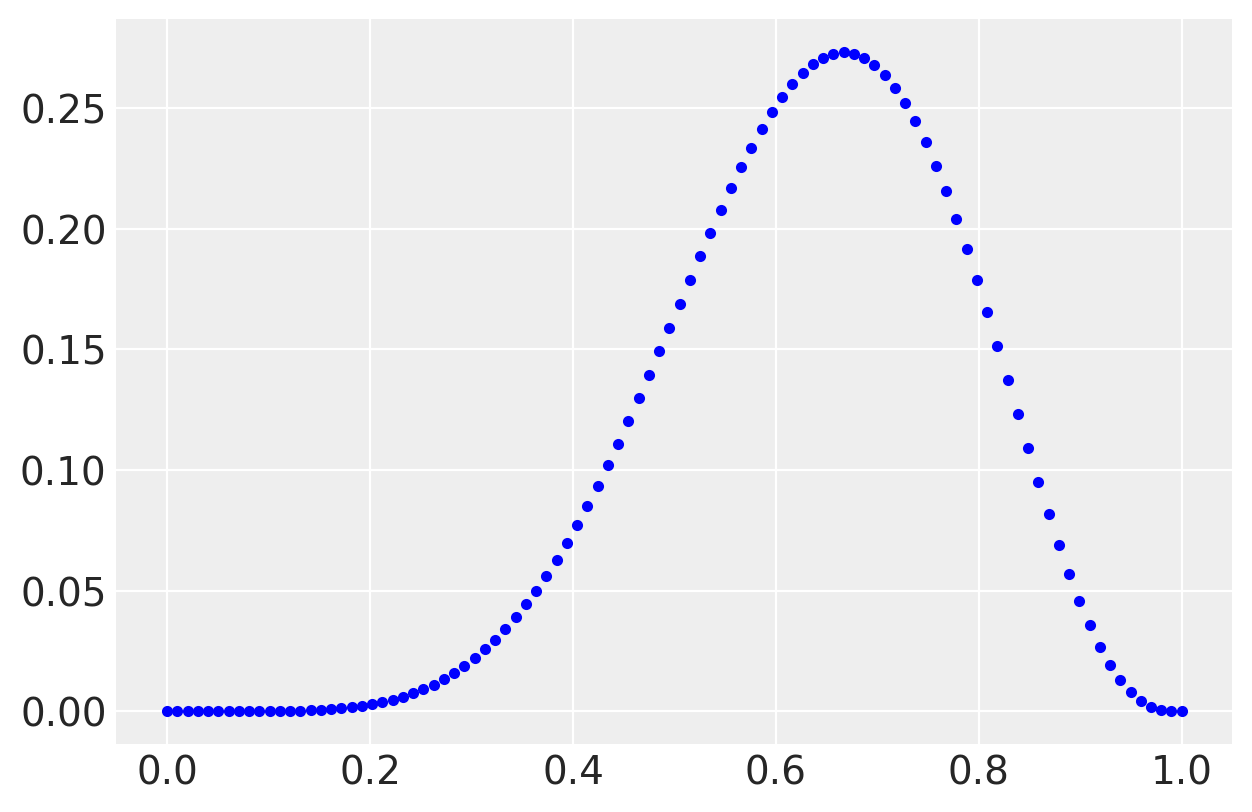

In [6]:
fig, ax = plt.subplots(1, 1)
success=6
tosses=9
p_grid = np.linspace(0, 1, 100)
likelihood = stats.binom.pmf(success, tosses, p_grid)
ax.plot(p_grid, likelihood, 'bo', ms=3, label='binom pmf')
#ax.vlines(p_grid, 0,likelihood, colors='b', lw=5, alpha=0.5)

### p=0.4 이고, 9번 던지는  경우, 앞면이 나오는 횟수에 따른 likelihood Pr(W|N,p)

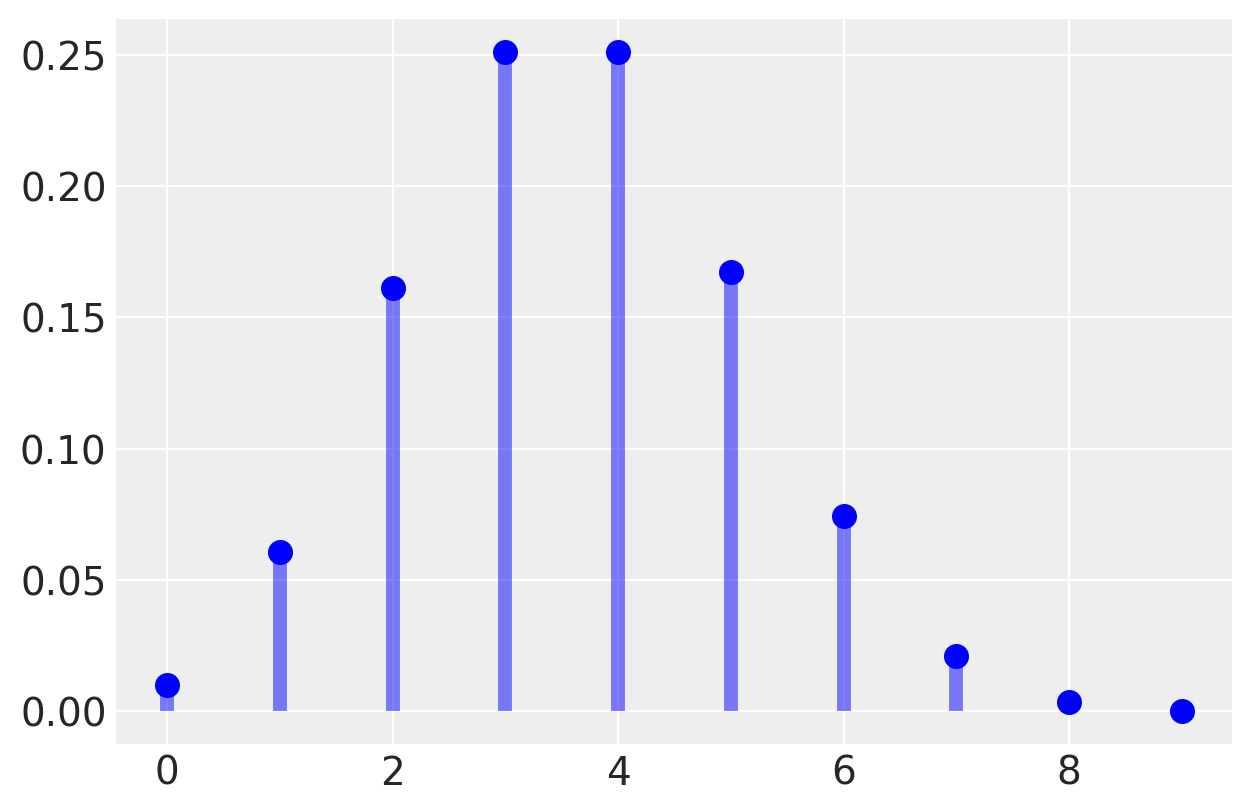

In [7]:
fig, ax = plt.subplots(1, 1)
success_grid=np.arange(10)  # 정수
tosses=9
p = 0.4
likelihood = stats.binom.pmf(success_grid, tosses, p)
ax.plot(success_grid, likelihood, 'bo', ms=8, label='binom pmf')
ax.vlines(success_grid, 0,likelihood, colors='b', lw=5, alpha=0.5)

### p=0.4 이고,  앞면이 6번 나오는 경우, 던진 횟수에 따른 likelihood Pr(N|W,p)

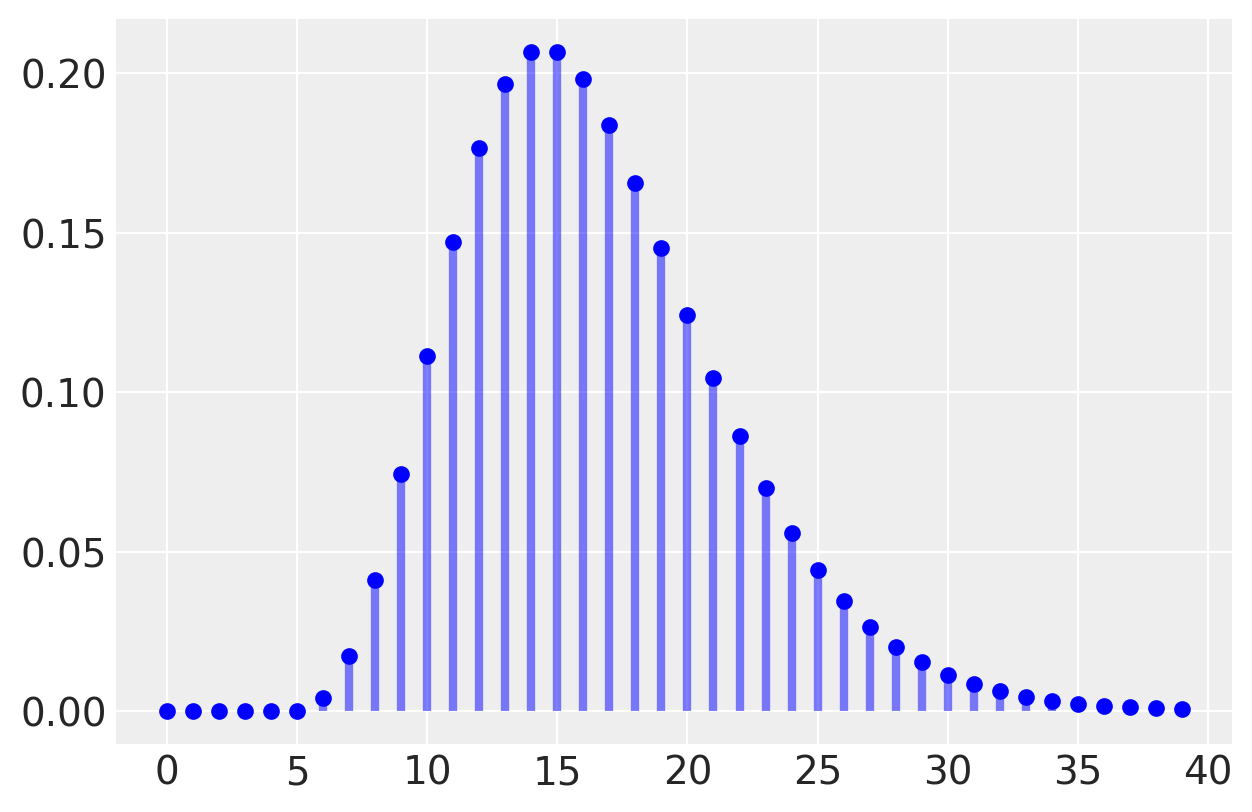

In [8]:
fig, ax = plt.subplots(1, 1)
success=6  
tosses_grid=np.arange(40)
p = 0.4
likelihood = stats.binom.pmf(success, tosses_grid, p)
ax.plot(tosses_grid, likelihood, 'bo', ms=5, label='binom pmf')
ax.vlines(tosses_grid, 0,likelihood, colors='b', lw=3, alpha=0.5)

#### Code 3.2 - 3.5

We are goint to use the same function we use on chapter 2 (code 2.3)

In [9]:
def posterior_grid_approx(grid_points=100, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(1, grid_points)  # uniform # prior = array([1,1,1...,1])
    #prior = (p_grid >= 0.5).astype(int)  # truncated
    #prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

In [10]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

<br><br><br>
<img style="float: left;" src="pic/02_02_3.png"  width="850">

In [11]:
aa_milne_arr = ['pooh', 'rabbit', 'piglet', 'Christopher']
np.random.choice(aa_milne_arr, 10, p=[0.5, 0.1, 0.1, 0.3])


array(['pooh', 'pooh', 'pooh', 'rabbit', 'pooh', 'piglet', 'Christopher',
       'Christopher', 'pooh', 'pooh'], dtype='<U11')

In [12]:
samples.shape

(10000,)

In [13]:
samples

array([0.43434343, 0.64646465, 0.58585859, ..., 0.68686869, 0.54545455,
       0.34343434])

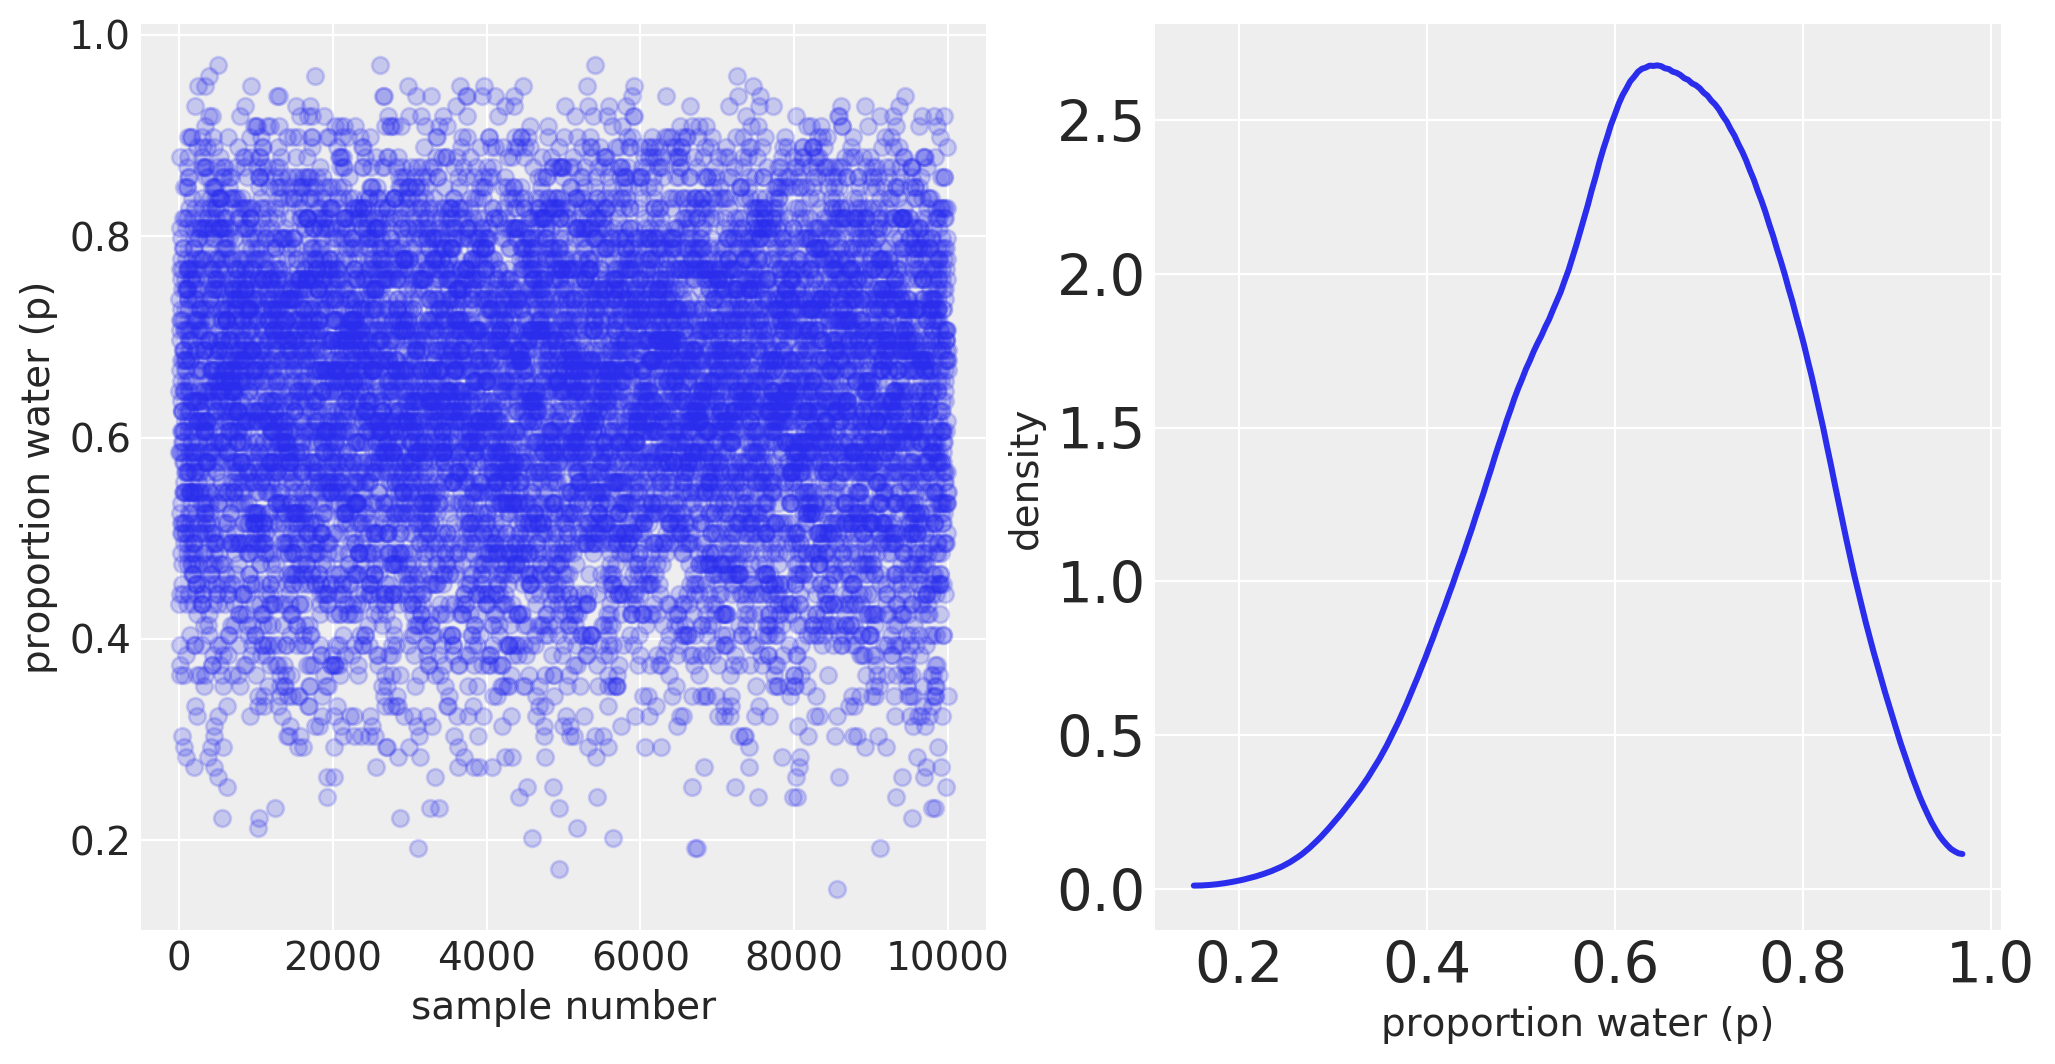

In [14]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
ax0.plot(samples, 'o', alpha=0.2)
ax0.set_xlabel('sample number', fontsize=14)
ax0.set_ylabel('proportion water (p)', fontsize=14)
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel('proportion water (p)', fontsize=14)
ax1.set_ylabel('density', fontsize=14);

In [15]:
posterior.shape

(100,)

In [16]:
samples.shape

(10000,)

<br><br><br>
<img style="float: left;" src="pic/02_03.png"  width="550">

#### Code 3.6

In [17]:
sum(posterior[ p_grid < 0.5 ])

0.17183313110747478

#### Code 3.7

In [18]:
sum( samples < 0.5 ) / 1e4

0.1713

#### Code 3.8

In [19]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6068

<br><br><br>
<img style="float: left;" src="pic/02_04.png"  width="550">

#### Code 3.9

In [20]:
np.percentile(samples, 80)

0.7575757575757577

In [21]:
sum(samples < 0.7575757575757577)/1e4

0.7781

In [22]:
sum(samples < 0.7575757575757578 ) / 1e4

0.8024

#### Code 3.10

In [23]:
np.percentile(samples, [10, 90])

array([0.44444444, 0.81818182])

#### Code 3.11

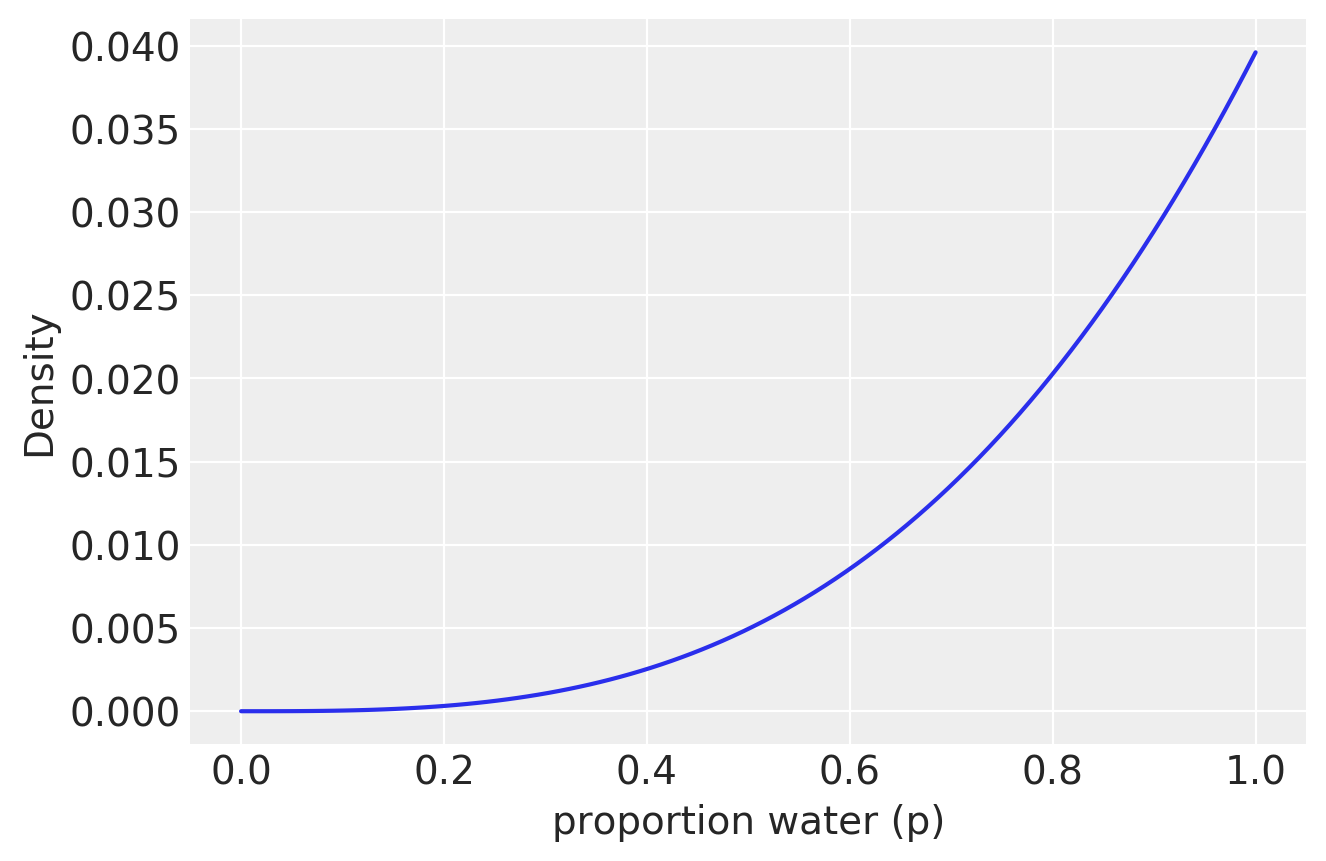

In [24]:
p_grid, posterior = posterior_grid_approx(success=3, tosses=3)
plt.plot(p_grid, posterior)
plt.xlabel('proportion water (p)', fontsize=14)
plt.ylabel('Density', fontsize=14);

<br><br><br>
<img style="float: left;" src="pic/02_05.png"  width="550">

#### Code 3.12

In [25]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
np.percentile(samples, [25, 75])

array([0.71717172, 0.93939394])

#### Code 3.13

In [26]:
#az.hpd(samples, credible_interval=0.5)

<br><br><br>
<img style="float: left;" src="pic/02_06.png"  width="550">

#### Code 3.14: 
#### maximum a posteriori (MAP) estimate: the parameter value with highest posterior probability

In [27]:
p_grid[posterior == max(posterior)]

array([1.])

#### Code 3.15

In [28]:
stats.mode(samples)[0]

array([0.98989899])

#### Code 3.16

In [29]:
np.mean(samples), np.median(samples)

(0.8055212121212122, 0.8484848484848485)

####  Loss: true p 와의 difference로 정의하자

#### Code 3.17: 만일 true p = 0.5 라면 loss는

In [30]:
sum(posterior * abs(0.5 - p_grid)) # posterior는 p=0 ~ p=1 사이의 probability 이다. abs(0.5 - p)는 각 p와 0.5 사이의 차이이다.

0.31626874808693

In [31]:
sum(posterior)

1.0000000000000002

In [32]:
abs(0.5-p_grid)

array([0.5       , 0.48989899, 0.47979798, 0.46969697, 0.45959596,
       0.44949495, 0.43939394, 0.42929293, 0.41919192, 0.40909091,
       0.3989899 , 0.38888889, 0.37878788, 0.36868687, 0.35858586,
       0.34848485, 0.33838384, 0.32828283, 0.31818182, 0.30808081,
       0.2979798 , 0.28787879, 0.27777778, 0.26767677, 0.25757576,
       0.24747475, 0.23737374, 0.22727273, 0.21717172, 0.20707071,
       0.1969697 , 0.18686869, 0.17676768, 0.16666667, 0.15656566,
       0.14646465, 0.13636364, 0.12626263, 0.11616162, 0.10606061,
       0.0959596 , 0.08585859, 0.07575758, 0.06565657, 0.05555556,
       0.04545455, 0.03535354, 0.02525253, 0.01515152, 0.00505051,
       0.00505051, 0.01515152, 0.02525253, 0.03535354, 0.04545455,
       0.05555556, 0.06565657, 0.07575758, 0.08585859, 0.0959596 ,
       0.10606061, 0.11616162, 0.12626263, 0.13636364, 0.14646465,
       0.15656566, 0.16666667, 0.17676768, 0.18686869, 0.1969697 ,
       0.20707071, 0.21717172, 0.22727273, 0.23737374, 0.24747

In [33]:
len(posterior)

100

<br><br><br>
<img style="float: left;" src="pic/02_07.png"  width="550">

#### Code 3.18 and 3.19

In [34]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]
p_grid[loss == min(loss)]

array([0.84848485])

#### Code 3.20
#### n=2, p=0.7 일때 success의 갯수 - 수식으로부터 구함

In [35]:
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

#### Code 3.21: 시뮬레이션, 랜덤하게 한번 실행함

In [36]:
stats.binom.rvs(n=2, p=0.7, size=1)

array([0])

#### Code 3.22: 랜덤하게 10번 실행

In [37]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([1, 2, 2, 1, 1, 2, 2, 1, 2, 1])

#### Code 3.23: 랜덤하게 100000번 실행

In [38]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w == i).mean() for i in range(3)]

[0.0904, 0.42095, 0.48865]

#### Code 3.24, 3.25 and 3.26: n=9, p=0.7 100000번 실행후 water가 나온 갯수별 횟수

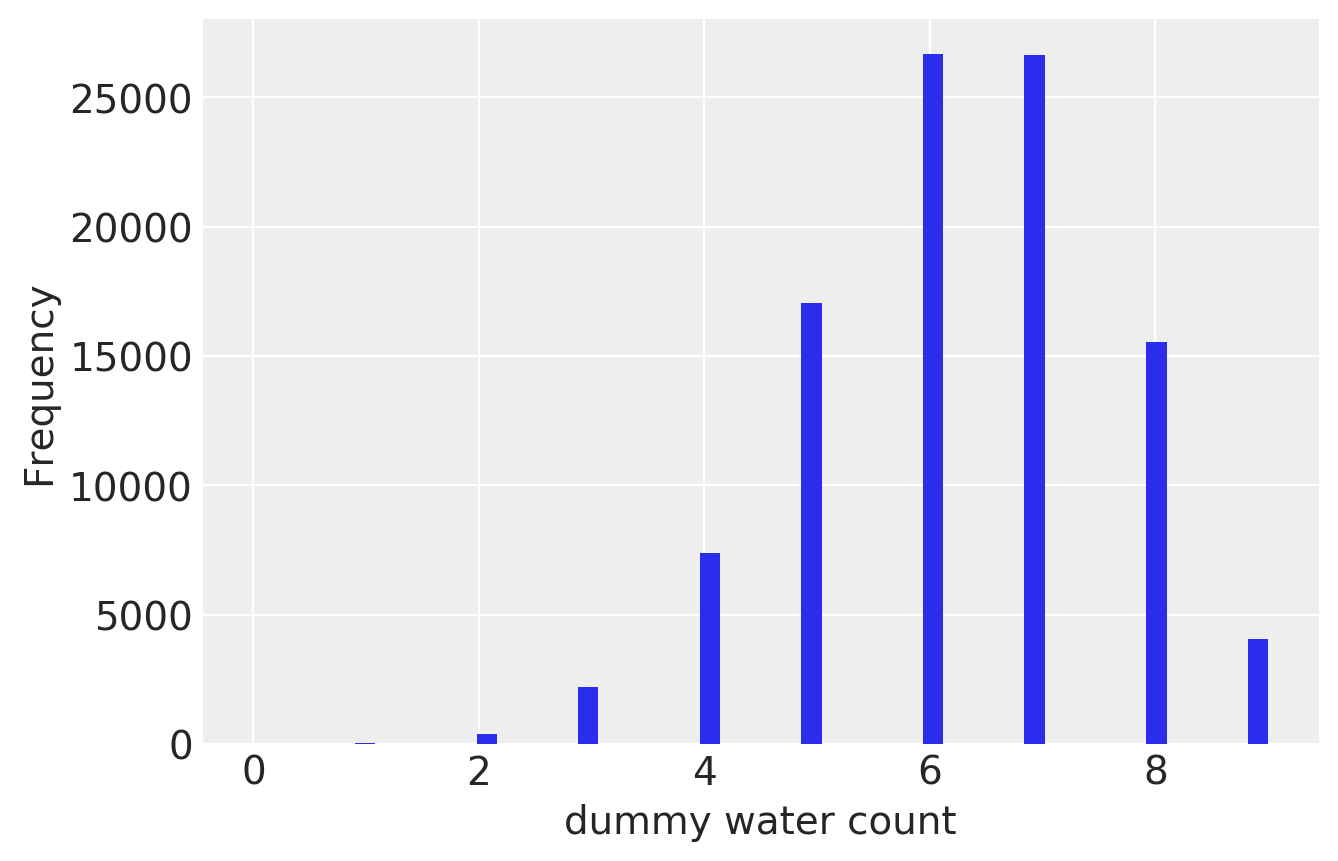

In [39]:
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
#dummy_w = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
#dummy_w = stats.binom.rvs(n=9, p=samples)
plt.hist(dummy_w, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

## 이하 생략

### 연습문제

#### Code 3.27

In [40]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

#### Code 3.28

In [41]:
birth1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0, 0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0, 1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])

#### Code 3.29

#### Code 3.30

In [42]:
sum(birth1) + sum(birth2)

111

In [43]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

NameError: name 'pm' is not defined